# Work on background radiation estimates for XMM-Newton

The idea is to identify observations where the radiation level is high, as those are likely to have strong Cu K$\alpha$ line (8.04 keV).


In [1]:
import os

import numpy as np

from astropy.table import Table
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

home = os.path.expanduser('~')

The radiation levels are read from Pedro Rodriguez folder and file:

In [2]:
#
# read the radiation monitor files from Pedro Rodriguez folder:
#
radmondir = '/home/prodrigu/XMM/Radiation/RADMON'
tx = Table.read(f'{radmondir}/rmle0bin.fits')
# convert to pandas dataframe
t = tx.to_pandas()
#
# interpolate the values
#
f = interp1d(t.TIME,t.RATE)
#
# the start date of the file is 1997-12-31T23:58:56Z
t0 = datetime.strptime('1997-12-31T23:58:56Z','%Y-%m-%dT%H:%M:%SZ')
min_time = t.TIME.min()
#

Now we read the list of XMM observations with revolution in [2500,3500], downloades as "csv" from [the internal observation log browser](http://xmm2.esac.esa.int/obs-cgi/obs_view.tcl).

In [3]:
tx = Table.read(f'{home}/IVAN/obs_list_rev2500-3500.csv',delimiter=';')
# convert to pandas
tobs = tx.to_pandas()
start = tobs['Exp Start Time']
end = tobs['Exp End Time']
rev = tobs['Revolution']
expo = tobs['Perf Duration']
mode = tobs['Mode']
# convert times, using list comprehension
time0 = [datetime.strptime(x,'%Y-%m-%d@%H:%M:%S') for x in start]
time1 = [datetime.strptime(x,'%Y-%m-%d@%H:%M:%S') for x in end]
#
obsid = tobs['Observation ID']
ncc = len(obsid)

Now will select the radiation monitor data within each OBS_ID star and end time and calculate the mean and st.dev.

In [4]:
# file to save the results

file_out = f'{home}/IVAN/Cu-line/PN_high_background.csv'
fout = open(file_out,'w')
print ("obsid,rev,mode,expo,mean_bkg,std_bkg",file=fout)
#
verbose = False
for i in np.arange(ncc):
    delta0 = (time0[i] - t0).total_seconds()
    delta1 = (time1[i] - t0).total_seconds()
    # pandas selection
    ttx = t[(t.TIME <= delta1) & (t.TIME >= delta0)]
    # if there is no match in the radiation file, then set to 0.0
    if (len(ttx) < 1):
        print ("No interval found for {:010}, mode={}, {}, {}".format(obsid[i],mode[i], time0[i],time1[i]))
        bkg = 0.0
        bkg_std = 0.0
    else:
        bkg = ttx.RATE.mean()
        bkg_std = ttx.RATE.std()
    print ("{:010}, {}, {}, {}, {:.2f}, {:.2f}".format(obsid[i],rev[i],mode[i],expo[i],bkg,bkg_std),file=fout)
    if (verbose):
        print ("{:010}, {}, {}, {}, {:.2f}, {:.2f}".format(obsid[i],rev[i],mode[i],expo[i],bkg,bkg_std))
#
fout.close()
print ("All done")

No interval found for 0761920701, mode=Full Frame, 2015-05-03 13:07:34, 2015-05-04 10:06:03
No interval found for 0770190301, mode=Full Frame, 2015-09-21 23:05:11, 2015-09-22 13:07:00
No interval found for 0810840101, mode=Small Window, 2018-10-19 07:01:19, 2018-10-20 02:10:23
No interval found for 0821722001, mode=Extended Full Frame, 2018-11-29 09:11:41, 2018-11-30 23:26:49
All done


Now ploting with [altair](https://altair-viz.github.io), interactive plot.

In [5]:
import os
import pandas as pd
import altair as alt

trad = pd.read_csv(file_out)

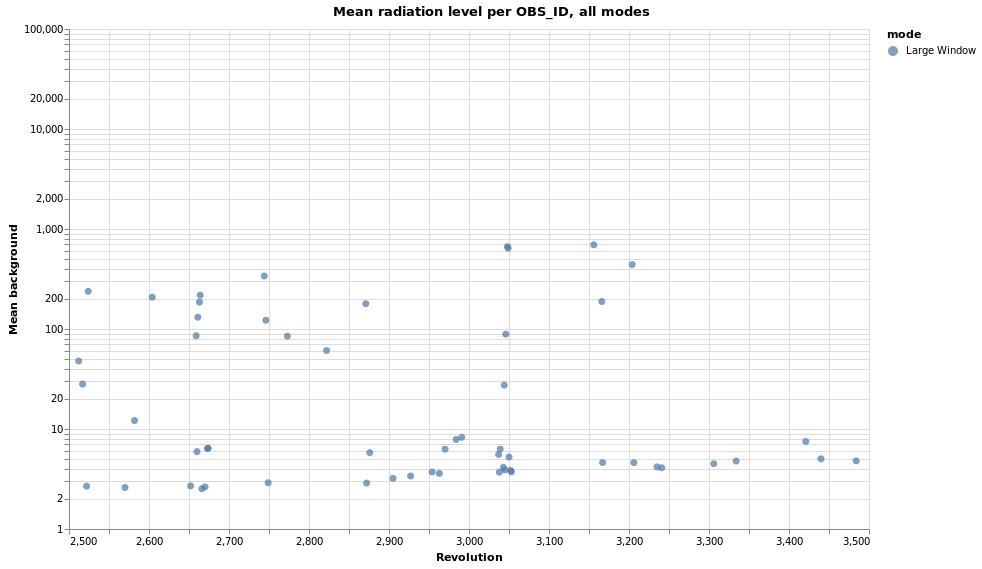

In [9]:
#
#
#select = "all"
#if (select == 'all'):
#    xtab = trad[trad.mean_bkg >= 1.0]

select = "Large"
xtab = trad[trad['mode'].str.contains(select)]

xtab = xtab[xtab.mean_bkg >= 1.0]

base = alt.Chart(xtab,title="Mean radiation level per OBS_ID, all modes",width=800,height=500)

points = base.mark_point(filled=True, size=50).encode(
    x=alt.X(
        "rev",
        scale=alt.Scale(domain=(2500,3500)),
        axis=alt.Axis(title='Revolution')
    ),
    y=alt.Y(
        'mean_bkg',
        scale=alt.Scale(type='log',domain=(1,50000)),
        axis=alt.Axis(title="Mean background")
    ),
    color='mode',
    tooltip=['rev', 'obsid','mean_bkg','std_bkg', 'mode']
)

# generate the error bars
errorbars = base.mark_rule().encode(
    x="rev",
    y="ymin:Q",
    y2="ymax:Q"
).transform_calculate(
    ymin="datum.mean_bkg-datum.std_bkg ",
    ymax="datum.mean_bkg+datum.std_bkg"
)

#points + errorbars

points

#chart.save("test_altair_plot.png")
#.mark_circle(size=60).encode(
#    alt.X('rev',scale=alt.Scale(domain=(2500,3500))),
#    alt.Y('mean_bkg',scale=alt.Scale(type="log")),
#    color='mode',
#    tooltip=['rev', 'obsid','mean_bkg', 'mode']
#).interactive()